In [4]:
import pandas as pd
wine = pd.read_csv("https://bit.ly/wine_data")
wine.head()#5개 미리보기
wine.info()#데이터들의 정보보기
wine.describe()#데이터의 간단한 통계보기


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [5]:
data = wine[['alcohol','sugar','pH']].to_numpy()
target = wine['class'].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split
train_input,test_input,train_target,test_target = train_test_split(data,target,test_size=0.2,random_state=42)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled,train_target)
print(lr.score(train_scaled,train_target))
print(lr.score(test_scaled,test_target))

0.7808350971714451
0.7776923076923077


In [13]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,max_depth=3)
dt.fit(train_scaled,train_target)
print(dt.score(train_scaled,train_target))
print(dt.score(test_scaled,test_target))

0.8454877814123533
0.8415384615384616


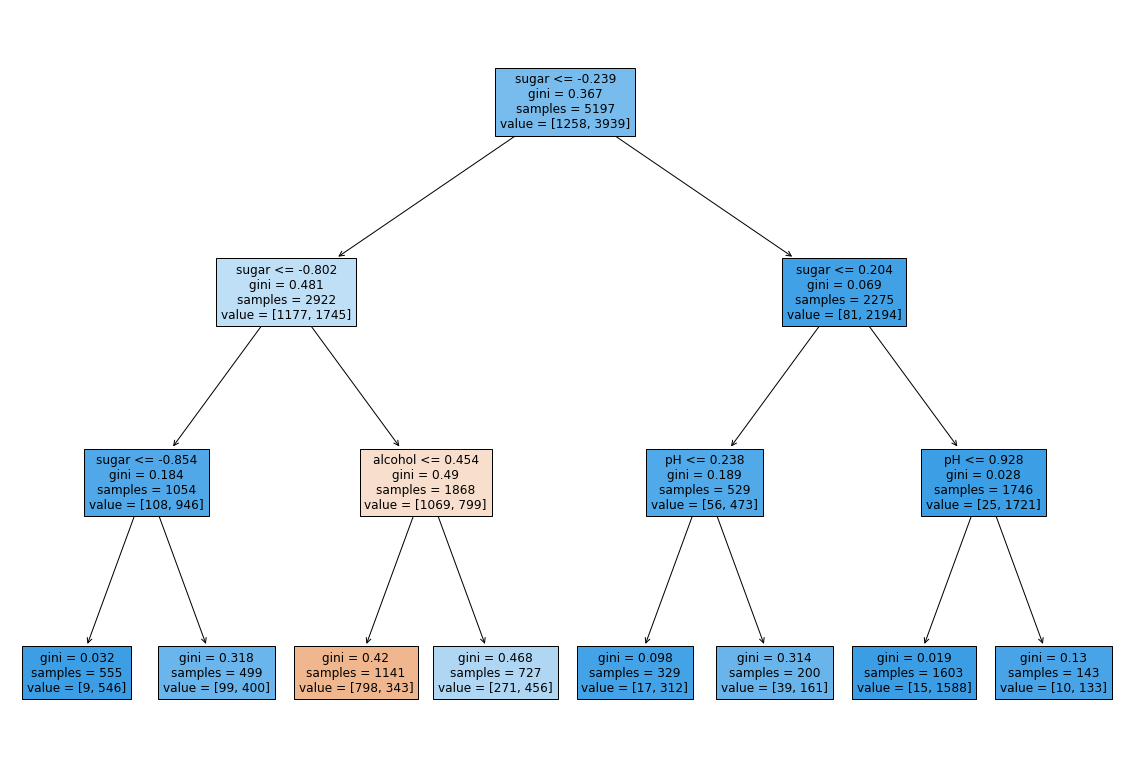

In [14]:
#설명하기 어려움 데이터를 scale 해 놓았기때문
#gini:불순도 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize = (20,14))
plot_tree(dt,filled=True,feature_names=['alcohol','sugar','pH'])
plt.show()

0.8454877814123533
0.8415384615384616


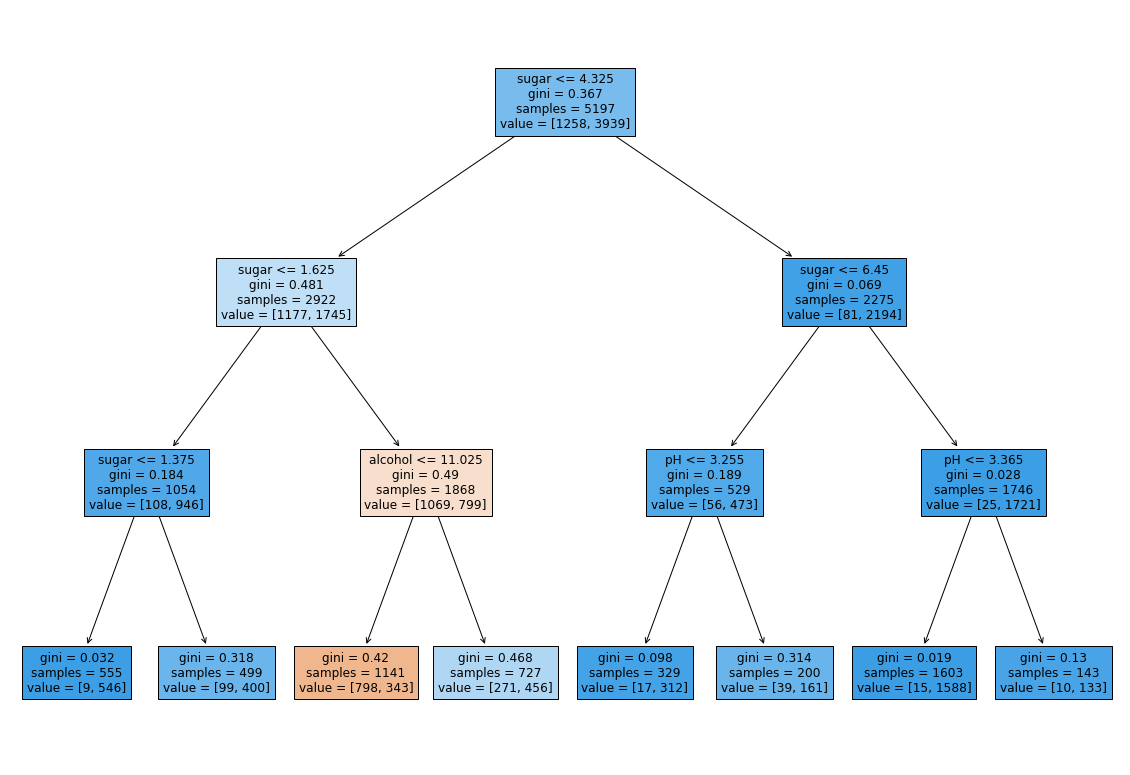

In [15]:
#scaled 되지 않은 값들로 설명하기 쉬움
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,max_depth=3)
dt.fit(train_input,train_target)
print(dt.score(train_input,train_target))
print(dt.score(test_input,test_target))
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize = (20,14))
plot_tree(dt,filled=True,feature_names=['alcohol','sugar','pH'])
plt.show()

In [18]:
#교차검증
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
splitter = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)# 이미 데이터 분할할때 셔플을 하지만 여기서 한번 더 해줄 수 있다.
scores = cross_validate(dt,train_input,train_target,cv=splitter)# 이미 데이터 분할할때 셔플을 하지만 여기서 한번 더 해줄 수 있다.
print(scores)
print(np.mean(scores['test_score']))

{'fit_time': array([0.00299907, 0.00430489, 0.00199771, 0.00256228, 0.00200319]), 'score_time': array([0.        , 0.        , 0.00100112, 0.        , 0.        ]), 'test_score': array([0.84230769, 0.83365385, 0.84504331, 0.8373436 , 0.8479307 ])}
0.8412558303102096


In [25]:
#그리드서치를 사용하면 따로 우리가 지정하지 않아도 다양항 실험을 해준다
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': np.arange(0.0001,0.001,0.0001),
          'max_depth':range(5,20,1),'min_samples_split':range(2,100,10)}
        
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),params,n_jobs=-1)
gs.fit(train_input,train_target)
dt = gs.best_estimator_
print(dt.score(test_input,test_target))
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'])

0.8615384615384616
{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}
[0.85780355 0.85799604 0.85799604 ... 0.86126601 0.86165063 0.86357629]


In [27]:
#그냥 랜덤하게 돌려서 제일 좋은거 찾아주기
#아래에 만든 랜덤변수를 위에 코드에다가 넣어주기
from scipy.stats import uniform,randint
rgen = randint(0,10)
rgen.rvs(5)
ugen = uniform(0,1)
ugen.rvs(5)


array([0.58951533, 0.09984026, 0.34746046, 0.14656887, 0.58629179])

In [28]:
#랜덤포레스트 기법 -  전체특성 중 일부를 랜덤하게 선택하여 최선의 노드를 분할한다
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True,n_jobs = -1,random_state=42)#n_jobs는 cpu 를 병렬로 몇개까지 돌릴 것인지 정하는 것
rf.fit(train_input,train_target)
print(rf.oob_score_)#앙상블기법에는 부트스트랩 샘플을 만들어낸다 했다 -> 분명 안 뽑히는 데이터들이 있는데 그 데이터들을 가지고 테스트 하는 일종의 crossvalidate 점수

0.8934000384837406


In [33]:
#엑스트라 트리 - 전체특성 중 일부를 랜덤하게 선택하여 아무 노드나 분할한다 - 랜덤포레스트보다 조금 더 빠르다 아무거나 가지고 하기 때문에
from sklearn.ensemble import ExtraTreesClassifier
ef = RandomForestClassifier(n_jobs = -1,random_state=42)#n_jobs는 cpu 를 병렬로 몇개까지 돌릴 것인지 정하는 것
scores = cross_validate(ef,train_input,train_target,
                        return_train_score=True,n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']))
ef.fit(train_input,train_target)
print(ef.feature_importances_)

0.9973541965122431 0.8905151032797809
[0.23167441 0.50039841 0.26792718]


In [ ]:
#그레디언트부스팅 - 깊이가 얕은 결정트리를 사용하여 이전트리의 오차를 보완하는 방식 기본적으로 깊이 3의 결정트리 100개 사용한다
#결론적으로 과대적합에 강하고 일반적으로 일반화능력이 좋다 하지만 병렬처리가 불가능하다 그 이유는 당연히 연속적으로 트리를 추가하며 그레디언트를 하므로
from sklearn.ensemble import GradientBoostingClassifier
gd = GradientBoostingClassifier(random_state=42,n_estimators=500,learning_rate=0.2)
scores = cross_validate(gd,train_input,train_target,
                        return_train_score=True,n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']))
gd.fit(train_input,train_target)
print(gd.feature_importances_)

In [36]:
#히스토그램기반그레디언트부스팅 - 가장뛰어난 앙상블기법
#훈련데이터를256개의 구간으로 변환하여 사용하기 때문에 노드분할 속도가 빠르다
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb,train_input,train_target,
                        return_train_score=True,n_jobs=-1)
print(np.mean(scores['train_score']),np.mean(scores['test_score']))
hgb.fit(train_input,train_target)


0.9321723946453317 0.8801241948619236


HistGradientBoostingClassifier(random_state=42)